In [1]:
import numpy as np
import pandas as pd
import sys
from os.path import dirname
sys.path.append(dirname("../../src/"))

from parse_protein_symbols import entrez_dict
from process_labels.get_labels import get_go_labels

def get_labels(proteins,
               obofile,
               g2gofile,
               GOT = "F",
               min_level = 5,
               min_protein_annotation = 50,
               symbol_to_id = lambda x:x):
    """
    Get the protein GO labels corresponding to a given protein.
    """
    
    go_type = "molecular_function"
    go_type = "biological_process" if GOT=="P" else go_type
    go_type = "cellular_component" if GOT=="C" else go_type
    
    filter_protein = {"namespace": go_type, "lower_bound": min_protein_annotation}
    filter_labels  = {"namespace": go_type, "min_level": min_level}
    f_labels, labels_dict = get_go_labels(filter_protein,
                                          filter_labels,
                                          proteins,
                                          lambda x: x,
                                          g2gofile,
                                          obofile,
                                          verbose = True)
    
    return f_labels, labels_dict

## <span style="color:red">Get the HuRI human network and the proteins</span>

The annotated HuRi network is annotated with entrez Id.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import networkx as nx

# HISTOGRAM
degrees_hist = {}

# huri_G       = nx.read_edgelist("../../data/HuRi.entrez.tsv")
# huri_C       = sorted(nx.connected_components(G), reverse = True, key = len)[0]
# huri_GC      = huri_G.subgraph(huri_C)
# nx.write_edgelist(huri_GC, "../../data/HuRi.connected.entrez.tsv")

huri_network = pd.read_csv("../../data/HuRi.connected.entrez.tsv", delim_whitespace = True, header = None)
huri_prots   = set(huri_network[0]).union(set(huri_network[1]))
huri_occurences = list(huri_network[0]) + list(huri_network[1])
huri_network = huri_network.drop([2], axis = 1)
huri_network

,0,1
0,64102,6676
1,64102,23786
2,64102,665
3,64102,945
4,64102,11148
...,...,...
52082,7360,7360
52083,80863,80863
52084,6120,6120
52085,27010,27010


In [3]:
_, deg       = zip(*(collections.Counter(huri_occurences)).items()) 
deg_count    = collections.Counter(deg)
degrees_hist = [("HURI-complete", k, deg_count[k]) for k in range(1000)]

## <span style="color:red">Get the STRING human network and the proteins</span>

The annotated STRING network is also annotated with entrez Id.

In [4]:
string_network = pd.read_csv("../../data/human.STRING.entrez.tsv", sep = "\t", header = None)
string_prots   = set(string_network[0]).union(set(string_network[1]))
string_occurences = list(string_network[0]) + list(string_network[1])

_, deg       = zip(*(collections.Counter(string_occurences)).items()) 
deg_count    = collections.Counter(deg)
degrees_hist+= [("STRING-complete", k, deg_count[k]) for k in range(1000)]

## <span style="color:red">Get the SUB-network constructed from the intersection of HuRI and STRING proteins</span>

| Desc.          | Freq.|
|--------------- |------|
|STRING proteins | 7365 |
|HuRI proteins   | 8224 |
|Intersection    | 3855 |

In [5]:
cprot = string_prots.intersection(huri_prots)
hsub  = ~(huri_network[0].isin(cprot) & huri_network[1].isin(cprot))
ssub  = ~(string_network[0].isin(cprot) & string_network[1].isin(cprot))

huri_net   = huri_network.drop(huri_network.index[hsub])
string_net = string_network.drop(string_network.index[ssub])


# Get Degree stats of the shared HURI and STRING network
huri_s_occur   = list(huri_net[0]) + list(huri_net[1])
string_s_occur = list(string_net[0]) + list(string_net[1])

## HURI
_, hdeg = zip(*(collections.Counter(huri_s_occur)).items())
_, sdeg = zip(*(collections.Counter(string_s_occur)).items())

hcount  = collections.Counter(hdeg)
scount  = collections.Counter(sdeg)
degrees_hist += [("STRING-shared", k, scount[k])  for k in range(1000)]
degrees_hist += [("HURI-shared", k, hcount[k])  for k in range(1000)]

deg_df = pd.DataFrame(degrees_hist, columns = ["Network", "deg", "frequency"])

(0.0, 10.0)

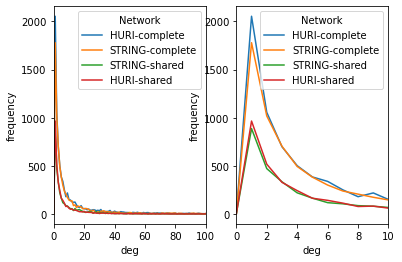

In [6]:
fig, [ax0, ax1] = plt.subplots(ncols=2)
sns.lineplot(data = deg_df, x = "deg", y = "frequency", hue="Network", ax=ax0)
ax0.set_xlim(0, 100)
sns.lineplot(data = deg_df, x = "deg", y = "frequency", hue="Network", ax=ax1)
ax1.set_xlim(0, 10)

# Analysis of the Link Prediction Scores 

In [7]:
def get_training_edges(G, training_perc = 0.75, test_neg_ratio = 20, k=5):
    training_edges = []
    test_edges     = []
    test_labels    = []
    mst            = nx.algorithms.tree.maximum_spanning_edges(G, 
                                                               algorithm="kruskal",
                                                              data = True)
    mst            = list(mst)
    R              = G.copy()
    R.remove_edges_from(mst)
    remaining      = R.edges(data = True)
    
    nodemap        = {i: k for i, k in enumerate(list(G.nodes()))}
    
    mst            = [(p, q, w[2]) for p, q, w in mst]
    remaining      = [(p, q, w[2]) for p, q, w in remaining]
    
    rem_n          = len(remaining)
    mst_n          = len(mst)
    
    remaining_r    = int(training_perc * (rem_n + mst_n) - mst_n)
    neg_count      = int(test_neg_ratio * (rem_n - remaining_r))
    print(f"Generating {k} Folds...")
    for i in range(k):
        print(f"\t{i}-th Fold...")
        ids = np.random.permutation(len(remaining))
        training_edges.append(mst + [remaining[i] for i in ids[:remaining_r]])
        
        test_edge  = [(remaining[i][0], remaining[i][1])  for i in ids[remaining_r:]]
        test_label = [1 for i in range(len(test_edge))]
                      
        tesposmap = {(p, q) for (p, q) in test_edge}
        n_testneg = 0
        neg_ids   = np.random.randint(len(nodemap), size=(neg_count+1000, 2))
        for i in range(neg_count + 1000):
            p_, q_ = neg_ids[i]
            if p_ == q_: 
                continue
            p      = nodemap[p_]
            q      = nodemap[q_]
            if (p, q) in tesposmap or (q, p) in tesposmap:
                continue
            n_testneg += 1
            test_edge.append((p, q))
            test_label.append(0)
            
            if n_testneg == neg_count:
                break
        test_edges.append(test_edge)
        test_labels.append(test_label)
        test_edge = None
    
    return training_edges, test_edges,  test_labels


In [8]:
huri_net[2]       = 1
string_net[2]     = 1
string_network[2] = 1
huri_network[2]   = 1

In [14]:
import networkx as nx
ss = nx.from_pandas_edgelist(string_net, 0, 1, 2)  # SHARED HURI
hs = nx.from_pandas_edgelist(huri_net, 0, 1, 2)     # SHARED HURI

# Had to do this for HuRi only. Works fine for STRING
hs_shared = sorted(nx.connected_components(hs), reverse = True, key = len)[0]
hs        = hs.subgraph(hs_shared)

sn = nx.from_pandas_edgelist(string_network, 0, 1, 2) # FULL STRING
hn = nx.from_pandas_edgelist(huri_network, 0, 1, 2) # FULL HURI

In [15]:
print("--STRING-S--")
ss_tr, ss_te, ss_label = get_training_edges(ss)
print("--HURI-S--")
hs_tr, hs_te, hs_label = get_training_edges(hs)
print("--STRING-H--")
sn_tr, sn_te, sn_label = get_training_edges(sn)
print("--HURI-H--")
hn_tr, hn_te, hn_label = get_training_edges(hn)

--STRING-S--
Generating 5 Folds...
	0-th Fold...
	1-th Fold...
	2-th Fold...
	3-th Fold...
	4-th Fold...
--HURI-S--
Generating 5 Folds...
	0-th Fold...
	1-th Fold...
	2-th Fold...
	3-th Fold...
	4-th Fold...
--STRING-H--
Generating 5 Folds...
	0-th Fold...
	1-th Fold...
	2-th Fold...
	3-th Fold...
	4-th Fold...
--HURI-H--
Generating 5 Folds...
	0-th Fold...
	1-th Fold...
	2-th Fold...
	3-th Fold...
	4-th Fold...


In [25]:
def compute_X_normalized(A, t = -1, lm = 1, is_normalized = True):
    n, _ = A.shape
    d    = A @ np.ones((n, 1))
    P    = A / d
    Identity = np.identity(A.shape[0])
    e = np.ones((A.shape[0], 1))

    D = np.diag(d.flatten())
    # Compute W
    scale = np.matmul(e.T, np.matmul(D, e))[0, 0]
    W = np.multiply(1 / scale, np.matmul(e, np.matmul(e.T, D)))

    up_P = np.multiply(lm, P - W)
    X_ = Identity - up_P
    X_i = np.linalg.pinv(X_)

    if t > 0:
        LP_t = Identity - np.linalg.matrix_power(up_P, t)
        X_i = np.matmul(X_i, LP_t)

    if is_normalized == False:
        return X_i

    # Normalize with steady state
    SS = np.sqrt(np.matmul(D, e))
    SS = 1 / SS
    SS = np.diag(SS.flatten())

    return np.matmul(X_i, SS)

def construct_neighbors_dict(training_graph):
    neighbors_dict = {}
    for p, q, _ in training_graph:
        for m, n in [(p, q), (q, p)]:
            neighbors_dict[m] = ([n] if m not in neighbors_dict 
                                 else neighbors_dict[m] + [n])
    return neighbors_dict

def construct_edge_dict(training_graph):
    edges = {}
    for p, q, w in training_graph:
        edges[(p, q)] = w
        edges[(q, p)] = w
    return edges

def predict_edges_cw(training_edges, test_pairs, neighbors_dict = None, edge_dict = None):
    if neighbors_dict == None:
        neighbors_dict = construct_neighbors_dict(training_edges)
    if edge_dict == None:
        edge_dict = construct_edge_dict(training_edges)
    
    scores = []
    for p, q in test_pairs:
        cw_score         = 0
        common_neighbors = set(neighbors_dict[p]).intersection(neighbors_dict[q])
        for n in common_neighbors:
            cw_score += edge_dict[p, n] + edge_dict[q, n]
        cw_score /= np.sqrt(len(neighbors_dict[p]) * len(neighbors_dict[q]))
        scores.append(cw_score)
    scores = np.array(scores) 
    return scores / np.max(scores)
                

def predict_edges_dsd(training_edges, test_pairs, normalized = False):
    # Compute Embedding
    ps, qs, ws = zip(*training_edges)
    nodes      = set(ps).union(set(qs))
    nodemap    = {k: i for i, k in enumerate(nodes)}
    n          = len(nodemap)
    A          = np.zeros((n, n))
    for p, q, w in training_edges:
        A[nodemap[p], nodemap[q]] = w
        A[nodemap[q], nodemap[p]] = w 
    X = compute_X_normalized(A, t = -1, lm = 1, is_normalized = normalized)
    
    # Compute distance
    scores     = []
    for p_, q_ in test_pairs:
        p = nodemap[p_]
        q = nodemap[q_]
        dist = np.linalg.norm(X[p] - X[q])
        scores.append(1 / (dist + 0.00001))
    scores     = np.array(scores)
    return scores / np.max(scores)




In [26]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
curves        = {}
table_results = [] # should be of the form (Dataset, Fold, Methodname, ScoreType, Value)

for tr, te, label, network in [(hs_tr, hs_te, hs_label, "HURI-SHARED"),
                                (hn_tr, hn_te, hn_label, "HURI-FULL"),
                                (ss_tr, ss_te, ss_label, "STRING-SHARED"),
                                (sn_tr, sn_te, sn_label, "STRING-FULL")]:
    print(f"Dataset: {network}...")
    for k in range(5):
        print(f"\tFold: {k}...")
        for method, mname in [(predict_edges_cw, "cw_normalized"),
                             (predict_edges_dsd, "dsd_unnormalized")]:
            print(f"\t\tMethod: {mname}")
            
            scores = method(tr[k], te[k])
            aupr   = average_precision_score(label[k], scores)
            roc    = roc_auc_score(label[k], scores)
            table_results.append((network, k, mname, "AUPR", aupr))
            table_results.append((network, k, mname, "ROC", roc))
            
            # AUPR
            prec, recall, thresholds = precision_recall_curve(label[k], scores)
            curves[f"{network}:{mname}:{k}:PREC"]   = prec
            curves[f"{network}:{mname}:{k}:RECALL"] = recall
        # DSD-NORMALIZED
        mname  = "dsd_normalized"
        print(f"\t\tMethod: {mname}")     
        scores = method(tr[k], te[k], normalized = True)
        aupr   = average_precision_score(label[k], scores)
        roc    = roc_auc_score(label[k], scores)
        table_results.append((network, k, mname, "AUPR", aupr))
        table_results.append((network, k, mname, "ROC", roc))
            
        # AUPR
        prec, recall, thresholds = precision_recall_curve(label[k], scores)
        curves[f"{network}:{mname}:{k}:PREC"]   = prec
        curves[f"{network}:{mname}:{k}:RECALL"] = recall

Dataset: HURI-SHARED...
	Fold: 0...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: dsd_normalized
	Fold: 1...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: dsd_normalized
	Fold: 2...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: dsd_normalized
	Fold: 3...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: dsd_normalized
	Fold: 4...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: dsd_normalized
Dataset: HURI-FULL...
	Fold: 0...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: dsd_normalized
	Fold: 1...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: dsd_normalized
	Fold: 2...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: dsd_normalized
	Fold: 3...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: dsd_normalized
	Fold: 4...
		Method: cw_normalized
		Method: dsd_unnormalized
		Method: dsd_normalized
Dataset: STRING-SHARED...
	Fold: 0...
		Method: cw_normalized
		Method: ds

In [27]:
df_table = pd.DataFrame(table_results)
df_table.columns = ["metwork", "k-folds", "method", "metric", "score"]
df_table

,0,1,2,3,4
0,HURI-SHARED,0,cw_normalized,AUPR,0.150574
1,HURI-SHARED,0,cw_normalized,ROC,0.650010
2,HURI-SHARED,0,dsd_unnormalized,AUPR,0.354428
3,HURI-SHARED,0,dsd_unnormalized,ROC,0.873783
4,HURI-SHARED,0,dsd_normalized,AUPR,0.507407
...,...,...,...,...,...
115,STRING-FULL,4,cw_normalized,ROC,0.910929
116,STRING-FULL,4,dsd_unnormalized,AUPR,0.766832
117,STRING-FULL,4,dsd_unnormalized,ROC,0.960001
118,STRING-FULL,4,dsd_normalized,AUPR,0.736438


In [30]:
df_table


,metwork,k-folds,method,metric,score
0,HURI-SHARED,0,cw_normalized,AUPR,0.150574
1,HURI-SHARED,0,cw_normalized,ROC,0.650010
2,HURI-SHARED,0,dsd_unnormalized,AUPR,0.354428
3,HURI-SHARED,0,dsd_unnormalized,ROC,0.873783
4,HURI-SHARED,0,dsd_normalized,AUPR,0.507407
...,...,...,...,...,...
115,STRING-FULL,4,cw_normalized,ROC,0.910929
116,STRING-FULL,4,dsd_unnormalized,AUPR,0.766832
117,STRING-FULL,4,dsd_unnormalized,ROC,0.960001
118,STRING-FULL,4,dsd_normalized,AUPR,0.736438


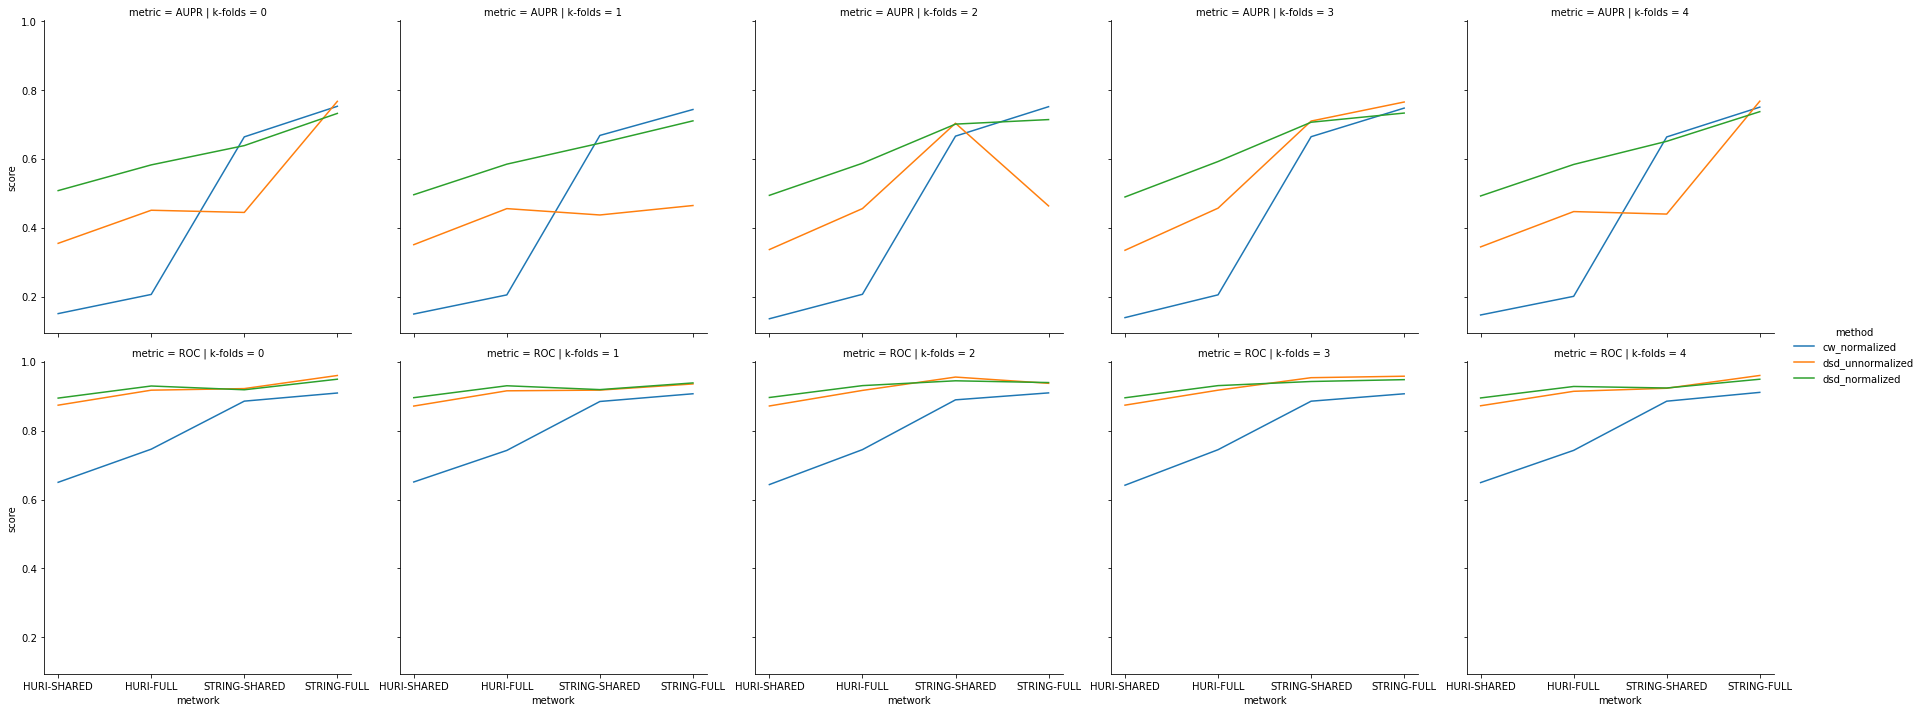

In [36]:
import seaborn as sns
sns.relplot(
    data = df_table,
    x="metwork",
    y="score",
    col="k-folds",
    hue="method",
    row="metric",
    kind = "line",
    sizes = (10, 100)
)
plt.savefig("link_prediction_results.png")
df_table.to_csv("link_prediction.tsv", sep = "\t", index = False)

## <span style="color:red"> Get GO labels for the Intersection Proteins </span>

The GO terms for MF, BP and CC hierarchies are >= 5

In [42]:
F_list, labels_F = get_labels(cprot,
                   "../../mg-attention/datasets/go/extracted/go-basic.obo",
                   "../../mg-attention/datasets/go/extracted/gene2go",
                   GOT = "F",
                   min_level = 5,
                   min_protein_annotation = 20,
                   symbol_to_id = lambda x:x)

HMS:0:00:02.150364 335,858 annotations, 20,671 genes, 18,441 GOs, 1 taxids READ: ../../mg-attention/datasets/go/extracted/gene2go 
18388 IDs in loaded association branch, molecular_function
  EXISTS: ../../mg-attention/datasets/go/extracted/go-basic.obo
../../mg-attention/datasets/go/extracted/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 Terms; optional_attrs(relationship)
Labels Obtained! The number of labels obtained is 35


In [43]:
P_list, labels_P = get_labels(cprot,
                   "../../mg-attention/datasets/go/extracted/go-basic.obo",
                   "../../mg-attention/datasets/go/extracted/gene2go",
                   GOT = "P",
                   min_level = 5,
                   min_protein_annotation = 50,
                   symbol_to_id = lambda x:x)

HMS:0:00:03.871301 335,858 annotations, 20,671 genes, 18,441 GOs, 1 taxids READ: ../../mg-attention/datasets/go/extracted/gene2go 
18388 IDs in loaded association branch, biological_process
  EXISTS: ../../mg-attention/datasets/go/extracted/go-basic.obo
../../mg-attention/datasets/go/extracted/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 Terms; optional_attrs(relationship)
Labels Obtained! The number of labels obtained is 44


In [44]:
C_list, labels_C = get_labels(cprot,
                    "../../mg-attention/datasets/go/extracted/go-basic.obo",
                    "../../mg-attention/datasets/go/extracted/gene2go",
                    GOT = "C",
                    min_level = 5,
                    min_protein_annotation = 30,
                    symbol_to_id = lambda x:x)

HMS:0:00:04.469913 335,858 annotations, 20,671 genes, 18,441 GOs, 1 taxids READ: ../../mg-attention/datasets/go/extracted/gene2go 
18388 IDs in loaded association branch, cellular_component
  EXISTS: ../../mg-attention/datasets/go/extracted/go-basic.obo
../../mg-attention/datasets/go/extracted/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 Terms; optional_attrs(relationship)
Labels Obtained! The number of labels obtained is 40


## <span style="color:red">Computation of Average RESNIK similarities for Both HURI and STRING </span>

In [35]:
from goatools.obo_parser import GODag
from goatools.associations import read_gaf
from goatools.semantic import TermCounts, get_info_content
from goatools.semantic import resnik_sim


godag = GODag("../../mg-attention/datasets/go/extracted/go-basic.obo")
assoc_f = read_gaf("../../mg-attention/datasets/go/extracted/go-human.gaf", namespace = "MF")
assoc_p = read_gaf("../../mg-attention/datasets/go/extracted/go-human.gaf", namespace = "BP")
assoc_c = read_gaf("../../mg-attention/datasets/go/extracted/go-human.gaf", namespace = "CC")

tcount_f = TermCounts(godag, assoc_f)
tcount_p = TermCounts(godag, assoc_p)
tcount_c = TermCounts(godag, assoc_c)

../../mg-attention/datasets/go/extracted/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 Terms
HMS:0:00:12.848073 608,616 annotations READ: ../../mg-attention/datasets/go/extracted/go-human.gaf 
18053 IDs in loaded association branch, MF
HMS:0:00:12.493695 608,616 annotations READ: ../../mg-attention/datasets/go/extracted/go-human.gaf 
17586 IDs in loaded association branch, BP
HMS:0:00:11.791421 608,616 annotations READ: ../../mg-attention/datasets/go/extracted/go-human.gaf 
18859 IDs in loaded association branch, CC


In [63]:
def sem_similarity_(go_id, go_ids, go_dag, term_counts, avg = False):
    """
    If avg == True, compute the average Resnik Similarity Instead.
    """
    sims = [resnik_sim(go_id, go_i, go_dag, term_counts) for go_i in go_ids]
    if avg:
        return np.average(sims)
    return np.max(sims)
    
def sem_similarity(gois_1, gois_2, go_dag, term_counts, avg = False):
    """
    If avg == True, use the average Resnik Similarity, provided in Pandey et. al.
    https://academic.oup.com/bioinformatics/article/24/16/i28/201569
    """
    if avg:
        sims = [sem_similarity_(g1, gois_2, go_dag, term_counts) for g1 in gois_1]
        return np.average(sims)

In [64]:
def get_prot_lab_map(labels):
    prot_maps = {}
    for l in labels:
        for prot in list(labels[l]):
            if prot not in prot_maps:
                prot_maps[prot]  = [l]
            else:
                prot_maps[prot] += [l]
    return prot_maps

prot_F = get_prot_lab_map(labels_F)
prot_P = get_prot_lab_map(labels_P)
prot_C = get_prot_lab_map(labels_C)

In [69]:
avg_results = {"MF": [], "BP": [], "CC": []}

hcf = 0
hcp = 0
hcc = 0
semf = 0.
semp = 0.
semc = 0.
for i, row in huri_net.iterrows():
    if row[0] in prot_F and row[1] in prot_F:
        sem   = sem_similarity(prot_F[row[0]], prot_F[row[1]], godag, tcount_f, avg = True)
        if sem != None:
            semf += sem
            hcf  += 1
    if row[0] in prot_P and row[1] in prot_P:
        sem   = sem_similarity(prot_P[row[0]], prot_P[row[1]], godag, tcount_p, avg = True)
        if sem != None:
            semp += sem
            hcp  += 1    
    if row[0] in prot_C and row[1] in prot_C:
        sem   = sem_similarity(prot_C[row[0]], prot_C[row[1]], godag, tcount_c, avg = True)
        if sem != None:
            semc += sem
            hcc  += 1
semf /= hcf
semc /= hcc
semp /= hcp

avg_results["MF"] += [semf]
avg_results["BP"] += [semp]
avg_results["CC"] += [semc]
#ss_F = lambda row: sem_similarity(prot_F[row[0]], prot_F[row[1]], go_dag, term_counts, avg = True) if row[0] in prot_F and row[1] in prot_F else 0
#x    = huri_net.apply(ss_F)
# Average for HURI

In [70]:
hcf = 0
hcp = 0
hcc = 0
semf = 0.
semp = 0.
semc = 0.
for i, row in string_net.iterrows():
    if row[0] in prot_F and row[1] in prot_F:
        sem   = sem_similarity(prot_F[row[0]], prot_F[row[1]], godag, tcount_f, avg = True)
        if sem != None:
            semf += sem
            hcf  += 1
    if row[0] in prot_P and row[1] in prot_P:
        sem   = sem_similarity(prot_P[row[0]], prot_P[row[1]], godag, tcount_p, avg = True)
        if sem != None:
            semp += sem
            hcp  += 1    
    if row[0] in prot_C and row[1] in prot_C:
        sem   = sem_similarity(prot_C[row[0]], prot_C[row[1]], godag, tcount_c, avg = True)
        if sem != None:
            semc += sem
            hcc  += 1
semf /= hcf
semc /= hcc
semp /= hcp

avg_results["MF"] += [semf]
avg_results["BP"] += [semp]
avg_results["CC"] += [semc]
avg_results

{'MF': [1.2335388762249162, 1.511353394777959],
 'BP': [1.4047323355542256, 2.781250031037516],
 'CC': [1.0680052204453478, 1.4615708925529265]}

In [71]:
df_results = pd.DataFrame(avg_results)
df_results["Network"] = ["HuRI", "STRING-HUMAN"]

,MF,BP,CC
Network,,,
HuRI,1.233539,1.404732,1.068005
STRING-HUMAN,1.511353,2.781250,1.461571


## <span style="color:red">RESNIK Results for HURI And STRING ON THE SAME NETWORK</span>

In [76]:
df_results = df_results.set_index("Network")
df_results.to_csv("huri_string_results.tsv", sep = "\t")
df_results

,MF,BP,CC
Network,,,
HuRI,1.233539,1.404732,1.068005
STRING-HUMAN,1.511353,2.781250,1.461571


## <span style="color:red">5-fold Cross-validation on the STRING AND HuRI Networks </span> 

In [91]:
from scoring import kfoldcv, kfoldcv_sim, kfoldcv_with_pr
import numpy as np
import predict

def create_predictor(similarity_matrix, is_wt, confidence = True):
    def predictor(training_labels):
        tlabels_f = lambda i: (training_labels[i] if i in training_labels else [])
        if is_wt:
            return predict.wmv(similarity_matrix, tlabels_f, confidence = confidence)
        else:
            return predict.mv(similarity_matrix, tlabels_f, confidence = confidence)
    return predictor

def net_to_mat(df_net, prot):
    protmap = {k:i for i, k in enumerate(prot)}
    A       = np.zeros((len(protmap), len(protmap)))
    for i, r in df_net.iterrows():
        p = protmap[r[0]]
        q = protmap[r[1]]
        A[p, q] = 1.0
        A[q, p] = 1.0
    return protmap, A



In [80]:
map_S, string_A = net_to_mat(string_net, cprot)
map_H, huri_A   = net_to_mat(huri_net, cprot)

In [83]:
pid_F = {map_S[key]:val for key, val in prot_F.items()}
pid_P = {map_S[key]:val for key, val in prot_P.items()}
pid_C = {map_S[key]:val for key, val in prot_C.items()}

In [98]:
results = {"acc_F": [], "acc_P": [], "acc_C": [], "f1_P": [], "f1_C": []}

In [99]:
acc_f_huri = kfoldcv(5,
                     pid_F,
                     create_predictor(huri_A, is_wt = True, confidence = False) 
                    )
acc_f_string = kfoldcv(5,
                     pid_F,
                     create_predictor(string_A, is_wt = True, confidence = False) 
                    )

results["acc_F"] = [np.average(k) for k in [acc_f_huri, acc_f_string]]

acc_p_huri = kfoldcv(5,
                     pid_P,
                     create_predictor(huri_A, is_wt = True, confidence = False) 
                    )
acc_p_string = kfoldcv(5,
                     pid_P,
                     create_predictor(string_A, is_wt = True, confidence = False) 
                    )

results["acc_P"] = [np.average(k) for k in [acc_p_huri, acc_p_string]]

acc_c_huri = kfoldcv(5,
                     pid_C,
                     create_predictor(huri_A, is_wt = True, confidence = False) 
                    )
acc_c_string = kfoldcv(5,
                     pid_C,
                     create_predictor(string_A, is_wt = True, confidence = False) 
                    )

results["acc_C"] = [np.average(k) for k in [acc_c_huri, acc_c_string]]



In [100]:
f1_f_huri = kfoldcv_with_pr(5,
                     pid_F,
                     create_predictor(huri_A, is_wt = True) 
                    )
f1_f_string = kfoldcv_with_pr(5,
                     pid_F,
                     create_predictor(string_A, is_wt = True) 
                    )

results["f1_F"] = [np.average(k) for k in [f1_f_huri, f1_f_string]]

f1_p_huri = kfoldcv_with_pr(5,
                     pid_P,
                     create_predictor(huri_A, is_wt = True) 
                    )
f1_p_string = kfoldcv_with_pr(5,
                     pid_P,
                     create_predictor(string_A, is_wt = True) 
                    )

results["f1_P"] = [np.average(k) for k in [f1_p_huri, f1_p_string]]

f1_c_huri = kfoldcv_with_pr(5,
                     pid_C,
                     create_predictor(huri_A, is_wt = True) 
                    )
f1_c_string = kfoldcv_with_pr(5,
                     pid_C,
                     create_predictor(string_A, is_wt = True) 
                    )

results["f1_C"] = [np.average(k) for k in [f1_c_huri, f1_c_string]]



In [105]:
df_mv = pd.DataFrame(results)

In [106]:
df_mv["network"] = ["HuRI", "STRING"]

In [107]:
df_mv.set_index("network")

,acc_F,acc_P,acc_C,f1_P,f1_C,f1_F
network,,,,,,
HuRI,0.13625,0.177971,0.370664,0.231698,0.399948,0.215309
STRING,0.28000,0.363338,0.523400,0.405783,0.546200,0.340412


In [108]:
df_mv.to_csv("mv_results.tsv", sep = "\t")

## <span style="color:red">Comparing HURI Training Results between Topsy-Turvy and D-SCRIPT </span> 

<AxesSubplot:xlabel='iteration'>

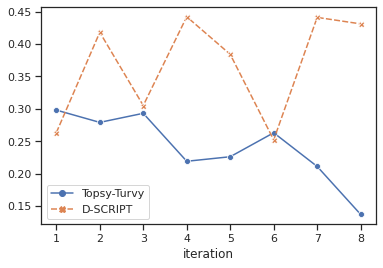

In [128]:
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_theme(style = "ticks")

ds_h = [0.263, 0.418, 0.305, 0.442, 0.384, 0.252, 0.441, 0.431]
tt_h = [0.298, 0.279, 0.293, 0.219, 0.226, 0.263, 0.211, 0.137]

ds_iter = np.arange(8) + 1

results = {"iteration": ds_iter, "Topsy-Turvy": tt_h, "D-SCRIPT": ds_h}

df_res  = pd.DataFrame(results)

df_res = df_res.set_index('iteration')
sns.lineplot(data = df_res, markers = True)

In [ ]:
"""
1) Degree Distribution Histogram of all of String, All of huri, string subnetwork and huri subnetwork. Hubs???
2) Redo resnik for all of STRING + all of GO
3) Redo the predictor: which filters out nodes based on degrees
4) Enzyme classification number. xxx
5) Threshold issue??? xxx
"""
